# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)


xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Load data

In [2]:
ds = pyxpcm.tutorial.open_dataset('argo').load()
ds

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source D

## Define/fit/predict a standard pyXpcm

In [3]:
from pyxpcm.models import pcm

In [4]:
# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z}
features_in_ds = {'temperature': 'TEMP'}

features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

In [5]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Debugging

Use option ``debug`` to print log messages 

In [6]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.clean()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds)

> Start preprocessing for action 'fit'

	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in the input axis, not need to interpolate, simple intersection
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))] X INTERPOLATED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X SCALED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X REDUCED with success)
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 38.825077

## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [7]:
# Create a PCM and use several methods to time:
m = pcm(K=8, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [8]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   51.106930
                           2-feature_temperature  1-ravel                245.905876
                                                  2-interp                 1.080275
                                                  3-scale_fit            584.243059
                                                  4-scale_transform      233.374119
                                                  5-reduce_fit            22.937059
                                                  6-reduce_transform       3.501892
                                                  total                 1091.207743
                           total                                        4166.110039
                           3-homogeniser          total                    2.616644
                           2-feature_salinity     1-ravel                222.576857
       

### Compare details of steps for each method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-score,6-xarray,score
Method,,,,,,,,,
fit,8329.874516,3330.626726,NaN,13.963938,NaN,NaN,NaN,NaN,NaN
fit_predict,3957.875729,4144.562960,NaN,26.190758,NaN,10.072708,13.854027,478.214979,NaN
predict,4665.610075,NaN,13.15093,NaN,531.499863,NaN,NaN,NaN,19.834995


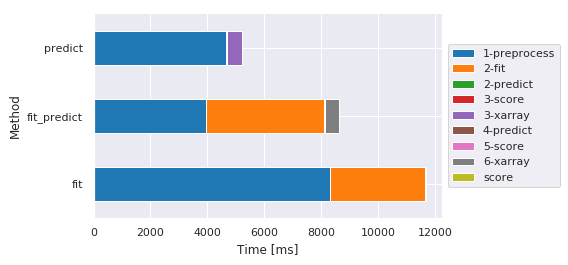

In [9]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Compare preprocessing steps for each method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,51.106930,1926.281691,2182.250023,2.616644,1.509190
fit_predict,51.659822,948.312759,974.721193,2.254248,1.163006
predict,26.643038,1192.912102,1108.980417,1.349926,1.847982


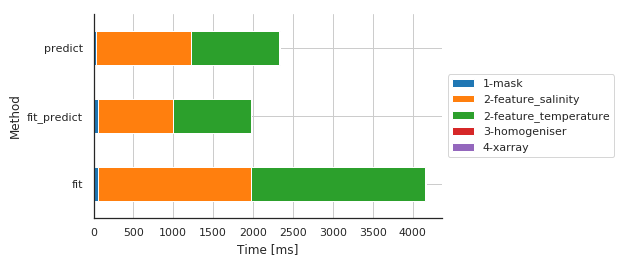

In [10]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,468.482733,2.184153,1060.796976,460.803270,54.600954,7.195711
fit_predict,475.485563,2.479792,0.004768,476.279974,0.005245,7.108927
predict,533.695936,3.360033,0.004292,605.052233,0.004053,8.672237


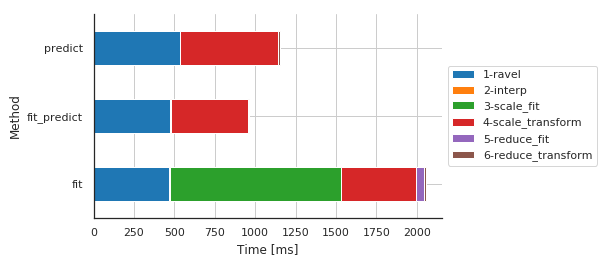

In [11]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.731118,0.004184,0.476558,0.778645,0.031669,0.011294
2-feature_temperature,0.746547,0.003840,0.584248,0.763490,0.022941,0.011683


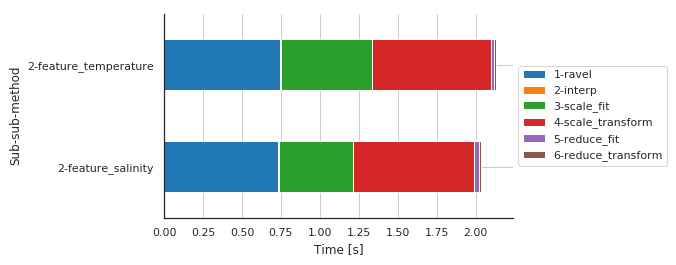

In [12]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df